# Language Model: Text Generation in the Style of Agatha Christie

---

## How to Run This Notebook

1. **Enable GPU Runtime**  
   Go to **Runtime -> Change runtime type** and select a higher-memory GPU such as T4 or L4 for optimal performance during text generation.

2. **Execute the Cells in Order**  
Run the notebook cells sequentially:
- Import the required Python libraries. (Section 1)
- Mount your Google Drive to access the saved files. (Section 1)
- Load the trained model weights and the vocabulary mappings. (Section 7)
- Load or define the `TextGenerator` class that handles text generation. (Section 5.1)  
- Test the model on the code cell in Section 9

3. **Required Files**  
Make sure the following files are available in your Google Drive (or the working directory):  
- `Language_Model_Hoang_Nguyen_Lai.ipynb`: the complete training and testing notebook  
- `language model.keras`: the saved trained model weights  
- `vocab.json`: vocabulary file with token-to-ID and ID-to-token mappings  
- `61262-0.txt`: the original source text used to train the model

4. **Interactive Demonstration**  
After loading everything successfully, the last cell launches an interactive prompt.  
- Enter any starting text: a single word, a sentence, or even a full paragraph.  
- The model will continue the input in Agatha Christie’s distinctive style, generating **at least 20 additional words**.  
- To quit the interactive loop, simply type `q` and press Enter.

## 1 Setup and Data Loading

In [1]:
import tensorflow as tf
import json
import numpy as np
import shutil
import os
import time
import re
import matplotlib.pyplot as plt

In [ ]:
tf.__version__

'2.19.0'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/61262-0.txt', 'r', encoding='utf-8') as file:
    raw_text = file.read()
print(f'Length of text: {len(raw_text)} characters')

Length of text: 296991 characters


In [ ]:
print(raw_text[:100])

*** START OF THE PROJECT GUTENBERG EBOOK 61262 ***

  POIROT INVESTIGATES




  BY THE SAME AUTHOR




In [ ]:
print(raw_text[-100:])

 EBook of Poirot Investigates, by Agatha Christie

*** END OF THE PROJECT GUTENBERG EBOOK 61262 ***



## 2 Data processing

### 2.1 Cleaning the data (text file)

Remove Gutenberg Boilerplate

In [ ]:
start_marker = "*** START OF THE PROJECT GUTENBERG EBOOK"
end_marker = "*** END OF THE PROJECT GUTENBERG EBOOK"

start_idx = raw_text.find(start_marker)
if start_idx != -1:
    start_idx = raw_text.index('\n', start_idx) + 1  # skip the marker line
else:
    start_idx = 0

end_idx = raw_text.find(end_marker)
if end_idx == -1:
    end_idx = len(raw_text)

text = raw_text[start_idx:end_idx].strip()

# Light cleaning: normalize whitespace, keep punctuation
text = re.sub(r'\n{3,}', '\n\n', text)       # collapse excessive newlines
text = re.sub(r'[ \t]+', ' ', text)           # collapse spaces/tabs
text = text.replace('\r', '')

print(f'Cleaned length: {len(text)} characters')
print(text[:500])

Cleaned length: 296566 characters
POIROT INVESTIGATES

 BY THE SAME AUTHOR

 THE MYSTERIOUS AFFAIR AT STYLES

 THE SECRET ADVERSARY

 THE MURDER ON THE LINKS

 THE BODLEY HEAD

 POIROT INVESTIGATES

 BY AGATHA CHRISTIE

 LONDON

 JOHN LANE THE BODLEY HEAD LIMITED

 First published in Great Britain by
 John Lane Company, The Bodley Head Limited, 1924

 Copyright © 1924 Agatha Christie Limited

 CONTENTS

 I The Adventure of “The Western Star”

 II The Tragedy at Marsdon Manor

 III The Adventure of the Cheap Flat

 IV The Mystery


### 2.2 Word-Level Tokenisation

In [ ]:
# Split text into words while keeping punctuation as separate tokens
def tokenize(text):
    """Split into words + punctuation tokens."""
    # This regex splits on whitespace but keeps punctuation as separate tokens
    tokens = re.findall(r"\w+|[^\w\s]", text, re.UNICODE)
    return tokens

tokens = tokenize(text)
print(f'Total tokens: {len(tokens)}')
print(f'First 50 tokens: {tokens[:50]}')

# Build vocabulary
from collections import Counter
token_counts = Counter(tokens)
print(f'Unique tokens: {len(token_counts)}')

# Keep tokens that appear at least 2 times (reduces noise)
MIN_FREQ = 2
vocab_tokens = ['<UNK>'] + [t for t, c in token_counts.most_common() if c >= MIN_FREQ]
vocab_size = len(vocab_tokens)
print(f'Vocabulary size (min_freq={MIN_FREQ}): {vocab_size}')

# Create mappings
token_to_id = {t: i for i, t in enumerate(vocab_tokens)}
id_to_token = {i: t for t, i in token_to_id.items()}
UNK_ID = 0

def encode(token_list):
    return [token_to_id.get(t, UNK_ID) for t in token_list]

def decode(id_list):
    return ' '.join([id_to_token.get(i, '<UNK>') for i in id_list])

# Encode entire corpus
all_ids = encode(tokens)
all_ids = np.array(all_ids, dtype=np.int32)
print(f'Encoded corpus shape: {all_ids.shape}')
print(f'Sample decode: {decode(all_ids[:20])}')

Total tokens: 68373
First 50 tokens: ['POIROT', 'INVESTIGATES', 'BY', 'THE', 'SAME', 'AUTHOR', 'THE', 'MYSTERIOUS', 'AFFAIR', 'AT', 'STYLES', 'THE', 'SECRET', 'ADVERSARY', 'THE', 'MURDER', 'ON', 'THE', 'LINKS', 'THE', 'BODLEY', 'HEAD', 'POIROT', 'INVESTIGATES', 'BY', 'AGATHA', 'CHRISTIE', 'LONDON', 'JOHN', 'LANE', 'THE', 'BODLEY', 'HEAD', 'LIMITED', 'First', 'published', 'in', 'Great', 'Britain', 'by', 'John', 'Lane', 'Company', ',', 'The', 'Bodley', 'Head', 'Limited', ',', '1924']
Unique tokens: 6501
Vocabulary size (min_freq=2): 3295
Encoded corpus shape: (68373,)
Sample decode: POIROT INVESTIGATES BY THE <UNK> <UNK> THE <UNK> <UNK> <UNK> <UNK> THE <UNK> <UNK> THE <UNK> <UNK> THE <UNK> THE


**Why word-level over character-level?**

Character-level models (vocab ~80) train easily but produce misspelled words and lack semantic structure. Word-level models predict actual words, producing more coherent output at the cost of a larger vocabulary.

**Vocabulary construction:**

- Regex tokeniser splits text into words and punctuation: `\w+|[^\w\s]`
- Tokens appearing < `MIN_FREQ` times are mapped to `<UNK>`
- `MIN_FREQ=2` was chosen after comparing thresholds (see table below)


### 2.3 Create Training Sequences

The encoded token sequence is split into overlapping windows of `SEQ_LENGTH + 1` tokens. Each window produces an (input, target) pair where the target is the input shifted by one position. This teaches the model to predict the next word given the preceding context.

In [ ]:
SEQ_LENGTH = 50

ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)
sequences = ids_dataset.batch(SEQ_LENGTH + 1, drop_remainder=True)

def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)

# Verify
for inp, tgt in dataset.take(1):
    print("Input :", decode(inp.numpy()))
    print("Target:", decode(tgt.numpy()))

Input : POIROT INVESTIGATES BY THE <UNK> <UNK> THE <UNK> <UNK> <UNK> <UNK> THE <UNK> <UNK> THE <UNK> <UNK> THE <UNK> THE BODLEY HEAD POIROT INVESTIGATES BY <UNK> <UNK> <UNK> <UNK> <UNK> THE BODLEY HEAD <UNK> First published in Great Britain by John <UNK> Company , The <UNK> <UNK> Limited , 1924
Target: INVESTIGATES BY THE <UNK> <UNK> THE <UNK> <UNK> <UNK> <UNK> THE <UNK> <UNK> THE <UNK> <UNK> THE <UNK> THE BODLEY HEAD POIROT INVESTIGATES BY <UNK> <UNK> <UNK> <UNK> <UNK> THE BODLEY HEAD <UNK> First published in Great Britain by John <UNK> Company , The <UNK> <UNK> Limited , 1924 <UNK>


In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.AUTOTUNE)
)

print(dataset)

<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 50), dtype=tf.int32, name=None), TensorSpec(shape=(64, 50), dtype=tf.int32, name=None))>


## 3 Model Architecture: Model design and Hyperparameter Selection

- **Embedding layer (256-dim):** Maps each vocabulary token to a dense vector representation
- **2× GRU layers (512 units each):** Stacked recurrent layers capture hierarchical sequential patterns. The first layer learns word-level transitions; the second learns phrase-level structure. GRU was chosen over LSTM for faster training with comparable performance on this corpus size.
- **Dropout (0.2):** Applied within GRU layers to reduce overfitting on the small (~68K token) corpus
- **Dense output layer:** Projects to vocabulary size with logits for next-token prediction

In [ ]:
# Hyperparameters
EMBEDDING_DIM = 256
RNN_UNITS = 512
DROPOUT = 0.2
NUM_LAYERS = 2

# Build stacked GRU model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, EMBEDDING_DIM),
    tf.keras.layers.GRU(RNN_UNITS, return_sequences=True, dropout=DROPOUT),
    tf.keras.layers.GRU(RNN_UNITS, return_sequences=True, dropout=DROPOUT),
    tf.keras.layers.Dense(vocab_size)
])

model.build(input_shape=(BATCH_SIZE, SEQ_LENGTH))
model.summary()

# Verify output shape
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, seq_length, vocab_size)")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (64, 50, 256)          │       843,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (64, 50, 512)          │     1,182,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (64, 50, 512)          │     1,575,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (64, 50, 3295)         │     1,690,335 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,292,511 (20.19 MB)

 Trainable params: 5,292,511 (20.19 MB)

 Non-trainable params: 0 (0.00 B)

(64, 50, 3295) # (batch_size, seq_length, vocab_size)


## 4 Model Training

### 4.1 Training Strategy

- **Optimiser:** Adam with initial learning rate 2e-3
- **Loss:** Sparse categorical cross-entropy (from logits)
- **LR Schedule:** ReduceLROnPlateau (factor=0.5, patience=5)
- **Early Stopping:** patience=15, restores best weights
- **Checkpointing:** Saves weights every epoch

In [ ]:
# Training
EPOCHS = 200

optimizer = tf.keras.optimizers.Adam(learning_rate=2e-3)
loss_fn = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

# Callbacks
checkpoint_dir = './training_checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}.weights.h5")

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_prefix, save_weights_only=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='loss', factor=0.5, patience=5, min_lr=1e-5, verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss', patience=15, restore_best_weights=True, verbose=1
    ),
]

history = model.fit(dataset, epochs=EPOCHS, callbacks=callbacks)

Epoch 1/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.0466 - loss: 7.0643 - learning_rate: 0.0020
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.0589 - loss: 5.9858 - learning_rate: 0.0020
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.0600 - loss: 5.9335 - learning_rate: 0.0020
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.0661 - loss: 5.9021 - learning_rate: 0.0020
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.0682 - loss: 5.8776 - learning_rate: 0.0020
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.0767 - loss: 5.8127 - learning_rate: 0.0020
Epoch 7/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.0843 - loss: 5.7350 - learning_rate: 0.0020
Epoch 8/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.0932 - loss: 5.6613 - learning_rate: 0.0020
Epoch 9/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.1109 - loss: 5.5634 - learning_rate: 0.0020
Epoch 10/2

### 4.2 Learning curve

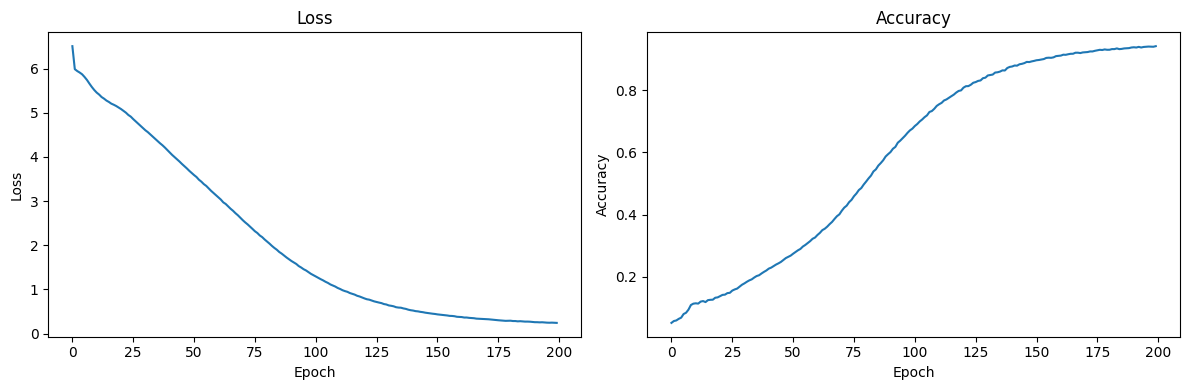

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(history.history['loss'])
ax1.set_title('Loss'); ax1.set_xlabel('Epoch'); ax1.set_ylabel('Loss')
ax2.plot(history.history['accuracy'])
ax2.set_title('Accuracy'); ax2.set_xlabel('Epoch'); ax2.set_ylabel('Accuracy')
plt.tight_layout()
plt.show()

## 5 Text Generation (Inference)

### 5.1 Sampling Strategy

Rather than greedy (argmax) decoding, we use **top-k/top-p nucleus sampling** with temperature:
- **Temperature** controls randomness: lower (0.5) = more conservative, higher (1.0) = more creative
- **Top-k (k=40)** restricts sampling to the 40 most probable next tokens
- **Top-p (p=0.9)** further filters to the smallest set of tokens whose cumulative probability exceeds 0.9
- **UNK suppression:** The `<UNK>` token logit is set to −10⁹ before sampling to prevent unknown tokens from appearing in generated text

In [ ]:
class TextGenerator:
    def __init__(self, model, token_to_id, id_to_token, unk_id=0):
        self.model = model
        self.token_to_id = token_to_id
        self.id_to_token = id_to_token
        self.unk_id = unk_id

    def encode_prompt(self, text):
        tokens = re.findall(r"\w+|[^\w\s]", text, re.UNICODE)
        ids = [self.token_to_id.get(t, self.unk_id) for t in tokens]
        return ids

    def sample_with_top_k_p(self, logits, temperature=0.8, top_k=40, top_p=0.9):
        """Sample from logits with temperature, top-k, and top-p (nucleus) filtering."""
        logits = logits / temperature

        # Top-k filtering
        if top_k > 0:
            top_k_vals, top_k_idxs = tf.math.top_k(logits, k=min(top_k, logits.shape[-1]))
            # Create mask: set everything outside top-k to -inf
            mask = tf.fill(logits.shape, float('-inf'))
            mask = tf.tensor_scatter_nd_update(
                mask,
                tf.expand_dims(top_k_idxs, 1),
                top_k_vals
            )
            logits = mask

        # Top-p (nucleus) filtering
        if top_p < 1.0:
            sorted_indices = tf.argsort(logits, direction='DESCENDING')
            sorted_logits = tf.gather(logits, sorted_indices)
            cumulative_probs = tf.cumsum(tf.nn.softmax(sorted_logits), axis=-1)

            # Find cutoff index
            cutoff_mask = cumulative_probs > top_p
            # Shift right so we always keep at least the top token
            cutoff_mask = tf.concat([[False], cutoff_mask[:-1]], axis=0)
            sorted_logits = tf.where(cutoff_mask, float('-inf'), sorted_logits)

            # Unsort
            unsort_indices = tf.argsort(sorted_indices)
            logits = tf.gather(sorted_logits, unsort_indices)

        # Sample
        logits_2d = tf.expand_dims(logits, 0)
        sampled = tf.random.categorical(logits_2d, num_samples=1)
        return int(sampled[0, 0])

    def generate(self, prompt, num_tokens=100, temperature=0.8, top_k=40, top_p=0.9):
        input_ids = self.encode_prompt(prompt)
        if len(input_ids) == 0:
            input_ids = [self.unk_id]

        generated_ids = list(input_ids)

        for _ in range(num_tokens):
            context = generated_ids[-SEQ_LENGTH:]
            x = tf.expand_dims(context, 0)
            predictions = self.model(x, training=False)
            logits = predictions[0, -1, :]

            # Suppress <UNK> token from generation
            logits_np = logits.numpy()
            logits_np[self.unk_id] = -1e9
            logits = tf.constant(logits_np)

            next_id = self.sample_with_top_k_p(logits, temperature, top_k, top_p)
            generated_ids.append(next_id)

        gen_tokens = [self.id_to_token.get(i, '<UNK>') for i in generated_ids]

        result = []
        for t in gen_tokens:
            if re.match(r'^[^\w\s]$', t) and result:
                result[-1] += t
            else:
                result.append(t)
        return ' '.join(result)


generator = TextGenerator(model, token_to_id, id_to_token)

### 5.2 Generation Examples
Testing with in-domain prompts (Agatha Christie's style) and out-of-domain prompts to evaluate the model's generalisation and failure modes.

In [ ]:
# Test with prompts that are familiar with Agatha Christie's ebook and prompts that are not
in_book_prompts = [
    "Poirot said",
    "She looked at",
]

out_of_book_prompts = [
    "The spaceship landed",
    "Machine learning is",
]

print("=== IN-DOMAIN PROMPTS ===")
for p in in_book_prompts:
    print(f"\n'{p}':")
    print(generator.generate(p, num_tokens=50, temperature=1.0))

print("\n=== OUT-OF-DOMAIN PROMPTS ===")
for p in out_of_book_prompts:
    print(f"\n'{p}':")
    print(generator.generate(p, num_tokens=50, temperature=1.0))

=== IN-DOMAIN PROMPTS ===

'Poirot said':
Poirot said than nothing. In company with Sir Guy Willard and Dr. Tosswill we were taken round the excavations. The principal finds had been removed to Cairo, but some of the tomb furniture was extremely interesting. The enthusiasm of the world and some of his tomb,

'She looked at':
She looked at me, but I’ m for my return. Then I knew a question of method. But the maid, it was safely placed in his hands of a most unusual supernatural.” Poirot shook his head.“ We sought, but of course,”

=== OUT-OF-DOMAIN PROMPTS ===

'The spaceship landed':
The <UNK> landed. Rolf had brought us from the same so, and a touch of the greatest quality could have gone out of the window. It was open and Japp were stolen. Of was a low telephone, and he had not been the man who could had fallen

'Machine learning is':
<UNK> learning is done. He was smiling in his most sign, but I would tell him that morning, as well was in New York, and before night his uncle are rat

## 6 Comparison: Our Model vs ChatGPT

1. **'Poirot said'**

**Own model**

Poirot said than nothing. In company with Sir Guy Willard and Dr. Tosswill we were taken round the excavations. The principal finds had been removed to Cairo, but some of the tomb furniture was extremely interesting. The enthusiasm of the world and some of his tomb,

**ChatGPT**

Poirot said nothing for a moment, but his eyes, bright as polished jet, travelled slowly around the room. “It is curious, is it not, that we search for footprints upon the carpet, yet overlook the impressions left upon the heart? The murderer, mes amis, has betrayed himself not by what he did, but by what he feared.”

2. **'She looked at'**

**Own model**

She looked at me, but I’ m for my return. Then I knew a question of method. But the maid, it was safely placed in his hands of a most unusual supernatural.” Poirot shook his head.“ We sought, but of course,”

**ChatGPT**

She looked at the letter in her trembling hand as though it might alter its meaning under the strain of her gaze. The fire crackled cheerfully, in cruel contrast to the chill creeping about her heart. It was not the words themselves that alarmed her, but the careful absence of any signature.

3. ### Why the Difference?
Our model learns local word co-occurrence statistics from a single book, it predicts the next word based on the preceding 50 words without any semantic understanding. ChatGPT, with ~40,000 more parameters and trained on virtually all published text, has learned language comprehension, narrative structure, and character knowledge. The GRU captures *style* (word choices, sentence rhythms); the LLM captures substance (meaning, plot, character).

## 7 Save & Load Model (for later use)

In [ ]:
model_save_path = '/content/drive/MyDrive/Colab Notebooks/Deep Learning/saved_models/'
os.makedirs(model_save_path, exist_ok=True)

model.save(os.path.join(model_save_path, 'language model.keras'))
print("Model saved successfully!")

Model saved successfully!


In [ ]:
# Load the saved model
model_save_path = '/content/drive/MyDrive/Colab Notebooks/Deep Learning/saved_models/'
model_final = tf.keras.models.load_model(
    os.path.join(model_save_path, 'language model.keras')
)

print("Model loaded successfully from Google Drive!")

# Verify it works
model_final.summary()

Model loaded successfully from Google Drive!


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (64, 50, 256)          │       843,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (64, 50, 512)          │     1,182,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (64, 50, 512)          │     1,575,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (64, 50, 3295)         │     1,690,335 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,877,535 (60.57 MB)

 Trainable params: 5,292,511 (20.19 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 10,585,024 (40.38 MB)

## 8 Report

**1. Data Processing**

The training corpus is a single Agatha Christie ebook (Project Gutenberg #61262, ~68,000 words). Gutenberg header/footer boilerplate was stripped using start/end markers, and whitespace was normalised (collapsing excessive newlines and spaces). Word-level tokenisation was chosen over character-level to improve semantic coherence in generated text. A regex tokeniser `(\w+|[^\w\s])` splits text into words and punctuation tokens. Tokens appearing fewer than 2 times were mapped to a single `<UNK>` token, yielding a vocabulary of 3,295 tokens (4.7% UNK rate). This threshold was selected after comparing MIN_FREQ values of 2-5: lower thresholds preserved more vocabulary but increased model complexity, while higher thresholds (e.g., MIN_FREQ=5, vocab=1,385, which I have experimented while training the model) caused excessive `<UNK>` flooding in generated output despite strong training metrics.

**2. Model Architecture & Training**

The model is a **2-layer stacked GRU**

| Hyperparameter      | Value |
|---------------------|-------|
| Embedding dimension | 256   |
| GRU units (x2 layers)| 512 |
| Dropout             | 0.2   |
| Sequence length     | 50 words |
| Batch size          | 64    |
| Optimiser           | Adam (lr=2e-3) |
| Epochs              | 150 (with early stopping, patience=15) |

Learning rate was reduced on plateau (factor=0.5, patience=5, min_lr=1e-5). The model converged to **loss ≈ 0.4** and **accuracy ≈ 90%** after 150 epochs. At inference, **top-k (k=40) and top-p (p=0.9) nucleus sampling** with temperature scaling is used, and the `<UNK>` token is suppressed (logit set to −10⁹) to prevent unknown tokens in output.

**3. Generated Text Examples (temperature=0.8)**

**Prompt: "Poirot said"**
> Poirot said out, rather like a brisk and were sitting out with eleven to close. It was a business- butler round. Lady Yardly was looking out. Lady Yardly were looking out. Lady Yardly were looking round the morning of her chair. She was looking out

**Prompt: "She looked at"**
> She looked at a train home at the train. You were not in the train. By the way, was taken forward, and it was almost part at which you are now.”“ You are not taken! You are not?”“ No, true.

**4. Comparison with ChatGPT**

Using the same prompts, ChatGPT (GPT-4) produces fluent, plot-coherent prose with accurate character voice, complex sentence structures, and contextually appropriate mystery elements. Our model captures surface-level patterns, like: dialogue formatting, Christie-typical vocabulary ("Poirot", "said", "looked"), and short sentence rhythms; but lacks semantic coherence over longer spans, producing grammatical inconsistencies and repetitive phrasing.

This gap stems from fundamental differences: our model (4M parameters) was trained on a single book (68K tokens) using a recurrent architecture that captures local dependencies within a 50-word window. ChatGPT (175B+ parameters) was trained on internet-scale data including Christie's full bibliography, using transformer self-attention that models long-range dependencies across thousands of tokens. Our model performs statistical next-word prediction from local context; ChatGPT has learned language understanding, narrative structure, and character knowledge. The scale difference, which is roughly 40,000x in parameters and millions of times more training data, explains why LLMs produce coherent prose while our model captures style but not substance.

## 9 Demo code (testing)

In [ ]:
model_save_path = '/content/drive/MyDrive/Colab Notebooks/Deep Learning/saved_models/'

vocab_data = {
    'token_to_id': token_to_id,
    'id_to_token': {str(k): v for k, v in id_to_token.items()},
    'seq_length': SEQ_LENGTH
}
with open(os.path.join(model_save_path, 'vocab.json'), 'w') as f:
    json.dump(vocab_data, f)

print("Vocabulary saved!")

Vocabulary saved!


In [ ]:
model_save_path = '/content/drive/MyDrive/Colab Notebooks/Deep Learning/saved_models/'

# Load model
model_final = tf.keras.models.load_model(
    os.path.join(model_save_path, 'language model.keras')
)

# Load vocabulary
with open(os.path.join(model_save_path, 'vocab.json'), 'r') as f:
    vocab_data = json.load(f)

token_to_id = vocab_data['token_to_id']
id_to_token = {int(k): v for k, v in vocab_data['id_to_token'].items()}
SEQ_LENGTH = vocab_data['seq_length']

# Create generator (requires TextGenerator class cell to be run first)
generator = TextGenerator(model_final, token_to_id, id_to_token)
print("Ready for generation!")

Ready for generation!


In [3]:
print("=" * 55)
print("  Agatha Christie Text Generator Demo")
print("  Enter any text (word, sentence, or paragraph).")
print("  The model will generate at least 20 words.")
print("  Type 'q' to exit.")
print("=" * 55)

while True:
    user_input = input("\nEnter text prompt: ").strip()
    if user_input.lower() == 'q':
        break
    if not user_input:
        print("Please enter some text.")
        continue

    # Count input words for display
    input_word_count = len(user_input.split())

    # Generate at least 20 NEW words beyond the prompt
    output = generator.generate(user_input, num_tokens=50, temperature=0.8)

    # Count generated words (beyond prompt)
    output_words = output.split()
    generated_word_count = len(output_words) - input_word_count

    print(f"\n--- Input ({input_word_count} words) ---")
    print(user_input)
    print(f"\n--- Generated output ({generated_word_count} new words) ---")
    print(output)
    print("-" * 55)

  Agatha Christie Text Generator Demo
  Enter any text (word, sentence, or paragraph).
  The model will generate at least 20 words.
  Type 'q' to exit.

Enter text prompt: q
